# DepthMaps

In [1]:
import cv2
import torch
import urllib.request
import os
from tqdm.auto import tqdm
import numpy as np


import matplotlib.pyplot as plt

model_type = "MiDaS_small"

midas = torch.hub.load("intel-isl/MiDaS", model_type)

midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform


IMGS_DIR = './data/easyportrait/images/'

filename = '000df70f-e23e-4738-8c14-1e71cd728080.jpg'
filepath = os.path.join(IMGS_DIR, 'val', filename)
img = cv2.imread(filepath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_batch = transform(img)
import time
start_ts = time.time()
with torch.no_grad():
    prediction = midas(input_batch)
    print(1000*(time.time()-start_ts))

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()


Using cache found in /home/artem/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/artem/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


86.43484115600586


Using cache found in /home/artem/.cache/torch/hub/intel-isl_MiDaS_master


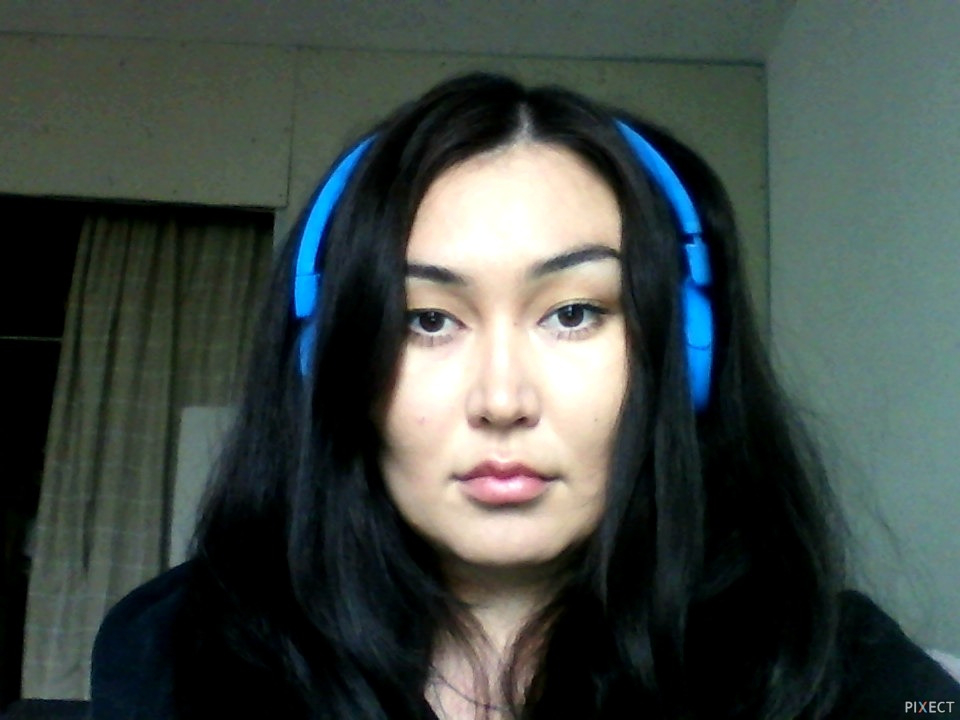

In [3]:
from PIL import Image
Image.open(filepath)

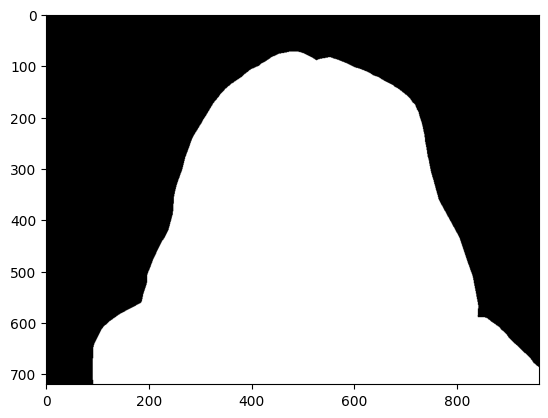

In [4]:
import numpy as np
import matplotlib.pyplot as plt

mask = cv2.imread(filepath.replace('images/', 'annotations/').replace('jpg', 'png'))
mask = np.where(mask > 0, np.ones_like(mask), np.zeros_like(mask))
plt.imshow(255*mask)

In [8]:
prediction.unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 720, 960])

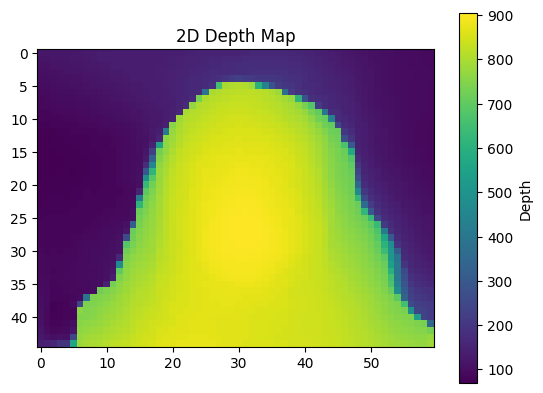

In [10]:
import torch.nn.functional as F
output = F.interpolate(prediction.unsqueeze(0).unsqueeze(0), scale_factor=1/16, mode='bilinear', align_corners=False).cpu().numpy().squeeze(0).squeeze(0)
plt.imshow(output, cmap='viridis')  # You can change the colormap as needed
plt.colorbar(label='Depth')
plt.title('2D Depth Map')
plt.show()

# SegFormer

In [1]:
from models.SegFormer.pipeline import segmentation_pipeline

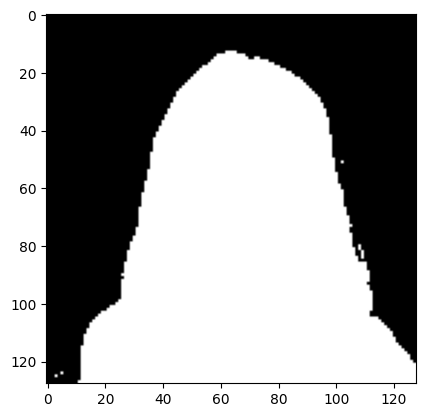

In [27]:
mask_pred = segmentation_pipeline(Image.open(filepath))[0].astype('uint8')
mask_pred = 1-np.repeat(np.expand_dims(mask_pred, -1), 3, -1)
plt.imshow(255*mask_pred)

## Visualization

In [56]:
TEST_SAMPLES = [
    '000df70f-e23e-4738-8c14-1e71cd728080',
    '0029ea44-eb9d-42cc-832b-66815cdf2236',
    '002db2a3-d8a0-4687-a7f3-e8c8b69bfbd9',
    '0044f136-faab-4ce8-849e-fc685b3b2f37',
    '006315b1-b839-4448-affa-90467c66d47b',
    '00c1f424-7961-4aae-9d5d-0b6c5f3d3ae5',
    '00c76d85-fc82-4292-84b7-d4bd6629c84e',
    '00df852b-c923-4962-945d-d7e0aa3f8874',
    '01047859-3924-4494-b9a7-bbba632042f0',
    '0104baec-92e2-4251-b335-3cfe37cee923'
]

IMG_DIR = 'data/easyportrait/images/val/'
MASK_DIR = 'data/easyportrait/annotations/val/'

In [44]:
from models.SegFormer.infer import build_pipeline as build_segformer_pipeline
# from models.SERNet_Former.infer import build_pipeline as build_sernet_pipeline
from models.SERSegFormer.infer import build_pipeline as build_serseg_pipeline

MODELS = [('SegFormer-B0', build_segformer_pipeline('checkpoints/segformer-b0/')),
          ('SERSeg_w_decoder', build_serseg_pipeline('checkpoints/serseg_w_decoder/'))]

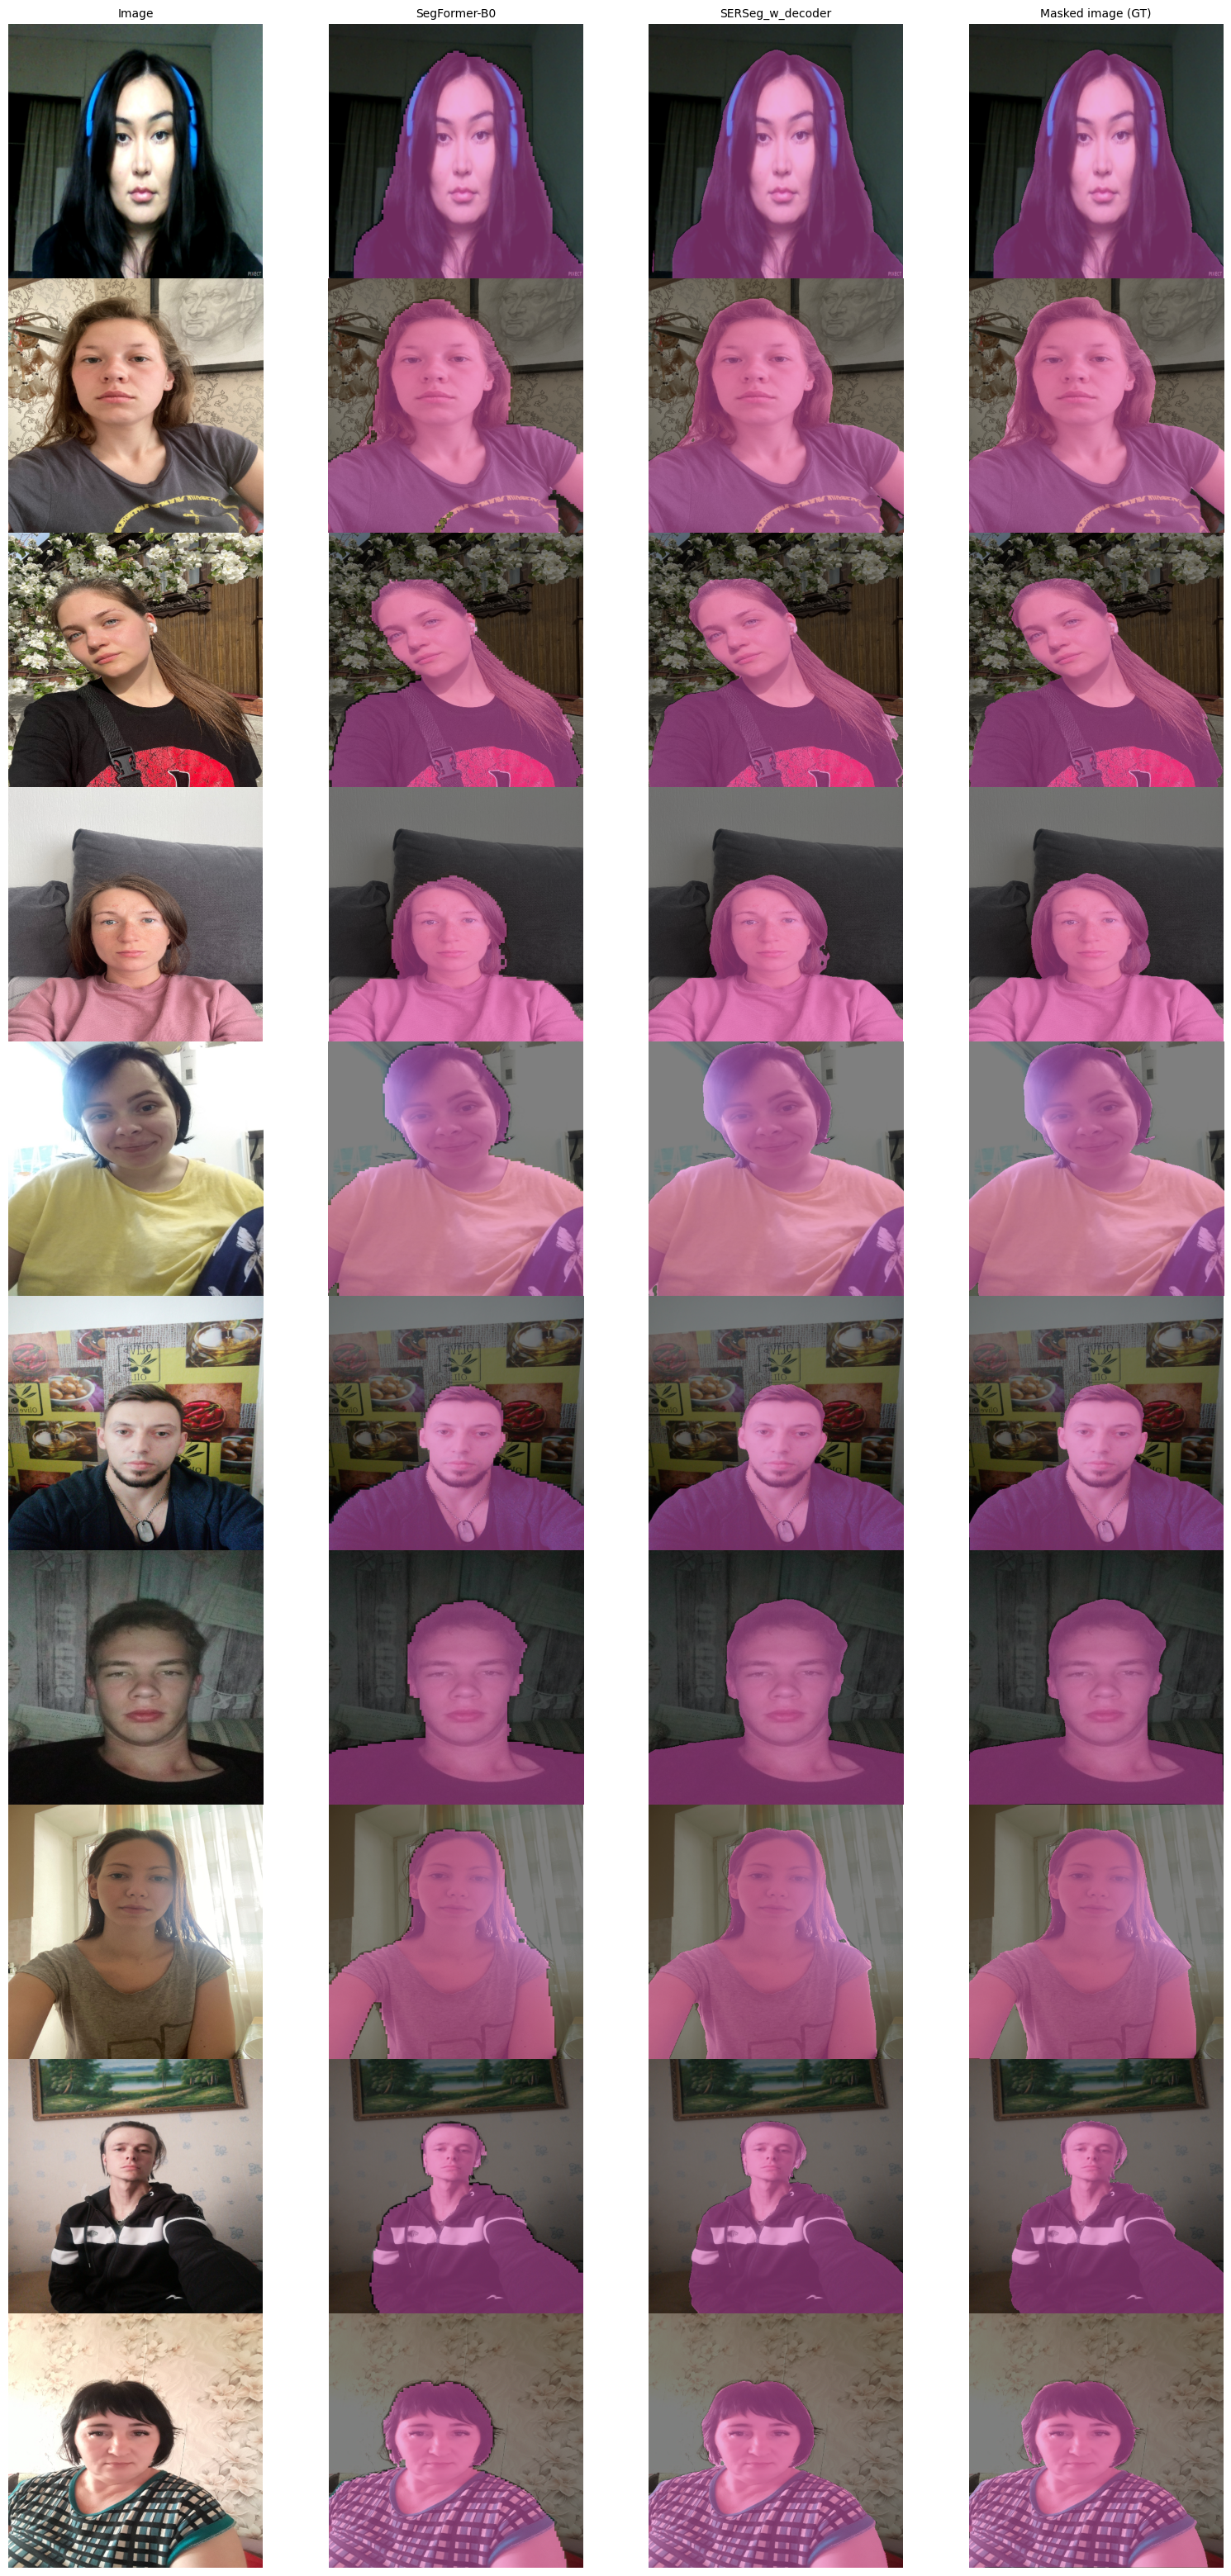

In [79]:
import numpy as np
import cv2
IMG_SIZE = (512,512)


ncols=2+len(MODELS)
fig, axes_list = plt.subplots(nrows=len(TEST_SAMPLES), ncols=ncols, figsize=(2*len(TEST_SAMPLES), 10*ncols))
plt.subplots_adjust(hspace = 0, wspace = 0)
    
orig_img_ax, mask_gt_ax = axes_list[0][0], axes_list[0][-1]

orig_img_ax.set_title('Image', fontsize=10)
mask_gt_ax.set_title('Masked image (GT)', fontsize=10)
for ax, model_name in zip(axes_list[0][1:-1], [x[0] for x in MODELS]):
    ax.set_title(model_name, fontsize=10)


DATASET_COLORS = [[0, 0, 0], [223, 87, 188], [160, 221, 255],
                  [130, 106, 237], [200, 121, 255], [255, 183, 255],
                  [0, 144, 193], [113, 137, 255], [230, 232, 230]]
DATASET_COLORS_BINARY = [[0,0,0], [223,87,188]]

palette = DATASET_COLORS_BINARY

for i, img_name in enumerate(TEST_SAMPLES):
    img = cv2.imread(os.path.join(IMG_DIR, img_name +'.jpg'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    
    mask_gt = cv2.imread(os.path.join(MASK_DIR, img_name+'.png'))[:, :, 0]
    img, mask_gt = [cv2.resize(x, IMG_SIZE) for x in [img, mask_gt]]
    mask_gt = np.where(mask_gt > 0, np.ones(IMG_SIZE), np.zeros(IMG_SIZE))
    
    axes_list[i][0].imshow(img)
    
    color_seg = np.zeros((mask_gt.shape[0], mask_gt.shape[1], 3), dtype=np.uint8)
    for label, color in enumerate(palette):
        color_seg[mask_gt == label, :] = color

    masked_image = img * 0.5 + color_seg * 0.5 
    masked_image = masked_image.astype(np.uint8)
    axes_list[i][-1].imshow(masked_image)
            
    

    for j, (model_name, model) in enumerate(MODELS):
        mask_pred = model(Image.fromarray(img)).squeeze(0)
        if mask_pred.shape != IMG_SIZE:
            mask_pred = cv2.resize(mask_pred, IMG_SIZE)
        mask_pred = 1 - mask_pred
        color_seg = np.zeros((mask_pred.shape[0], mask_pred.shape[1], 3), dtype=np.uint8)
        for label, color in enumerate(palette):
            color_seg[mask_pred == label] = color
    
        masked_image = img * 0.5 + color_seg * 0.5 
        masked_image = masked_image.astype(np.uint8)
        axes_list[i][1+j].imshow(masked_image)
    for ax in axes_list[i]:
        ax.set_axis_off()
    #     masks.append(1-np.repeat(np.expand_dims(mask_pred, -1), 3, -1))
    # masks.append(1-np.repeat(np.expand_dims(mask_gt, -1), 3, -1))


In [85]:
fig.savefig('res.jpeg')